In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pysr import PySRRegressor
from IPython.display import Markdown as md
import os

In [this article](https://arxiv.org/abs/2211.06393) J. Bayron Orjuela-Quintana et al. have found an explicit expression for the transfer function T(k):

$$ T(k;\omega_b,\omega_m) = [1+59.0998\ x^{1.49177}+4658.01\ x^{4.02755}+3170.79\ x^{6.06}+150.089\ x^{7.28478}]^{-\frac{1}{4}} $$

where
$$ x=\frac{k\ Mpc}{\omega_m-\omega_b} $$

and $\omega_i=\Omega_i h^2$, where $h$ is the reduced Hubble constant and $\Omega_i$ are the density parameters where $X = b,c,m,r,\nu,\gamma$ denotes baryons, CDM, pressure-less matter, radiation, neutrinos, photons, respectively.

First of all, let's import T(k) from CLASS:

In [6]:
notebook_folder = os.path.dirname('')
images_folder = os.path.join(notebook_folder, "..", "Images")
models_folder = os.path.join(notebook_folder, "..", "models", "pkl")
data_folder = os.path.join(notebook_folder, "..", "Data")
def data_path(data_id):
    return os.path.join(data_folder, data_id)
def model_path(model_id):
    return os.path.join(models_folder, model_id)
def img_path(img_id):
    return os.path.join(images_folder, img_id)
def save_img(img_id):
    plt.savefig(img_path(img_id) + ".pdf", format='pdf', bbox_inches='tight')

In [7]:
def T(x):
    a = (1 + 59.0998 * x**1.49177 + 4658.01 * x**4.02755 + 3170.79 * x**6.06 + 150.089 * x**7.28478)**(-1/4)
    return a

In [8]:
df_cl = pd.read_csv(data_path('TF_class.csv'))
df_cus = pd.read_csv(data_path('TF_custom.csv'))
df = pd.read_csv(data_path('TF_16.csv'))

Now, let's generate T(k)

In [9]:
h = 0.6781
k = np.logspace(np.log10(3 * 10 ** -5), np.log10(2),num=114,endpoint=True)
omega_b = 0.0223828 #omega baryon
omega_m = 0.1201075 #omega pressure-less matter
x = k/(omega_m-omega_b)
T_ = T(x)

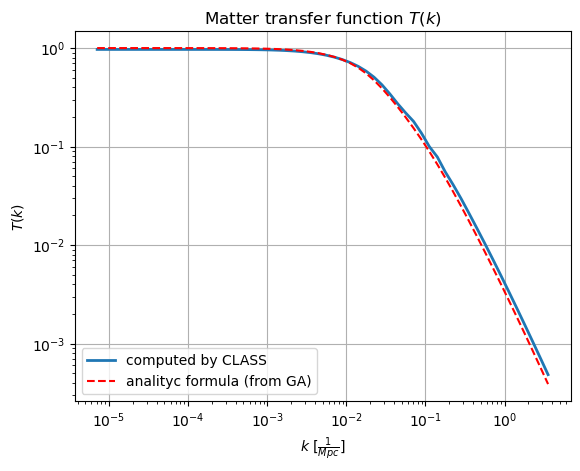

In [10]:
plt.plot(df_cus['k (1/Mpc)'],df_cus['T(k)'], label='computed by CLASS', lw=2)
plt.plot(df_cus['k (1/Mpc)'],T(df_cus['k (1/Mpc)']/(omega_m-omega_b)), label='analityc formula (from GA)', linestyle="--", color='r')
plt.xlabel(r'$k\ [\frac{1}{Mpc}]$')
plt.ylabel(r'$T(k)$')
plt.title(r"Matter transfer function $T(k)$")
plt.loglog()
plt.grid(True)
plt.legend()

I don't understand why I obtain a good accordance while I'm neglecting that the numerator of x is adimensional ($k\ Mpc$): in fact I used in the calculation only $k$, wich is dimensional ($[k]=\frac{1}{Mpc}$).

However, let's try to fit the analytic expression using PySR:

In [11]:
x = x.reshape(-1,1)
cluster = ["slurm", "pbs", "lsf", "sge", "qrsh", "scyld", "htc"]

In [12]:
model = PySRRegressor(
    model_selection="best",
    niterations=1000,  # < Increase me for better results
    binary_operators=["+","*","-","/","^"],
    constraints={'^': (2, 1)},
    nested_constraints={"^": {"^": 2}},
    maxsize=20,
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
    turbo=True,  
    #cluster_manager=cluster[1],
    #multithreading=True,
)

In [13]:
model.fit(x,T_)
print(model)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/julia_helpers.py:208: UserWarning: Your system's Python library is static (e.g., conda), so precompilation will be turned off. For a dynamic library, try using `pyenv` and installing with `--enable-shared`: https://github.com/pyenv/pyenv/blob/master/plugins/python-build/README.md#building-with---enable-shared.
  warnings.warn(


Started!

Expressions evaluated per second: 3.240e+05
Head worker occupation: 15.4%
Progress: 591 / 15000 total iterations (3.940%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.781e-01  1.673e-07  0.58659303
3           4.449e-04  2.996e+00  (0.05059631 ^ x0)
5           3.039e-04  1.905e-01  ((0.04161096 ^ x0) + 0.015036223)
7           8.740e-05  6.231e-01  (-0.11920547 / (-0.11778771 - (x0 ^ 1.3199131)))
9           4.247e-06  1.512e+00  (-0.11778771 / (-0.11778771 - ((x0 ^ 0.37392604) * x0)))
17          3.191e-06  3.572e-02  (-0.14355564 / ((-0.14355564 - (x0 ^ 1.3199131)) - ((x0 / (2.0...
                                  998728 + (x0 + 0.7169789))) * x0)))
19          3.179e-06  1.891e-03  (-0.14355564 / ((-0.14355564 - (x0 ^ 1.3199131)) - ((x0 / ((2....
                                  0998728 * 1.3199131) + (x0 / 0.95730394))) * x0)))
------------------

RuntimeError: <PyCall.jlwrap (in a Julia function called from Python)
JULIA: TaskFailedException
Stacktrace:
  [1] wait
    @ ./task.jl:349 [inlined]
  [2] fetch
    @ ./task.jl:369 [inlined]
  [3] _equation_search(parallelism::Symbol, datasets::Vector{Dataset{Float32, Float32, Matrix{Float32}, Vector{Float32}, Nothing, NamedTuple{(), Tuple{}}}}; niterations::Int64, options::Options{Int64, Optim.Options{Float64, Nothing}, typeof(loss), Nothing, StatsBase.Weights{Float64, Float64, Vector{Float64}}}, numprocs::Nothing, procs::Nothing, addprocs_function::Nothing, runtests::Bool, saved_state::Nothing)
    @ SymbolicRegression ~/.julia/packages/SymbolicRegression/xQVYy/src/SymbolicRegression.jl:735
  [4] _equation_search
    @ ~/.julia/packages/SymbolicRegression/xQVYy/src/SymbolicRegression.jl:425 [inlined]
  [5] equation_search(datasets::Vector{Dataset{Float32, Float32, Matrix{Float32}, Vector{Float32}, Nothing, NamedTuple{(), Tuple{}}}}; niterations::Int64, options::Options{Int64, Optim.Options{Float64, Nothing}, typeof(loss), Nothing, StatsBase.Weights{Float64, Float64, Vector{Float64}}}, parallelism::String, numprocs::Nothing, procs::Nothing, addprocs_function::Nothing, runtests::Bool, saved_state::Nothing)
    @ SymbolicRegression ~/.julia/packages/SymbolicRegression/xQVYy/src/SymbolicRegression.jl:412
  [6] equation_search(X::Matrix{Float32}, y::Matrix{Float32}; niterations::Int64, weights::Nothing, variable_names::Vector{String}, options::Options{Int64, Optim.Options{Float64, Nothing}, typeof(loss), Nothing, StatsBase.Weights{Float64, Float64, Vector{Float64}}}, parallelism::String, numprocs::Nothing, procs::Nothing, addprocs_function::Nothing, runtests::Bool, saved_state::Nothing, loss_type::Type, multithreaded::Nothing, varMap::Nothing)
    @ SymbolicRegression ~/.julia/packages/SymbolicRegression/xQVYy/src/SymbolicRegression.jl:345
  [7] equation_search
    @ ~/.julia/packages/SymbolicRegression/xQVYy/src/SymbolicRegression.jl:301 [inlined]
  [8] #equation_search#24
    @ ~/.julia/packages/SymbolicRegression/xQVYy/src/SymbolicRegression.jl:370 [inlined]
  [9] invokelatest(::Any, ::Any, ::Vararg{Any}; kwargs::Base.Pairs{Symbol, Any, NTuple{8, Symbol}, NamedTuple{(:weights, :niterations, :variable_names, :options, :numprocs, :parallelism, :saved_state, :addprocs_function), Tuple{Nothing, Int64, Vector{String}, Options{Int64, Optim.Options{Float64, Nothing}, typeof(loss), Nothing, StatsBase.Weights{Float64, Float64, Vector{Float64}}}, Nothing, String, Nothing, Nothing}}})
    @ Base ./essentials.jl:818
 [10] _pyjlwrap_call(f::Function, args_::Ptr{PyCall.PyObject_struct}, kw_::Ptr{PyCall.PyObject_struct})
    @ PyCall ~/.julia/packages/PyCall/ilqDX/src/callback.jl:32
 [11] pyjlwrap_call(self_::Ptr{PyCall.PyObject_struct}, args_::Ptr{PyCall.PyObject_struct}, kw_::Ptr{PyCall.PyObject_struct})
    @ PyCall ~/.julia/packages/PyCall/ilqDX/src/callback.jl:44

    nested task error: InterruptException:
    Stacktrace:
     [1] poptask(W::Base.IntrusiveLinkedListSynchronized{Task})
       @ Base ./task.jl:974
     [2] wait()
       @ Base ./task.jl:983
     [3] wait(c::Base.GenericCondition{Base.Threads.SpinLock}; first::Bool)
       @ Base ./condition.jl:130
     [4] wait(c::Base.GenericCondition{Base.Threads.SpinLock})
       @ Base ./condition.jl:125
     [5] _wait(t::Task)
       @ Base ./task.jl:308
     [6] wait
       @ ./task.jl:347 [inlined]
     [7] fetch
       @ ./task.jl:369 [inlined]
     [8] (::SymbolicRegression.var"#55#84"{Vector{Vector{Task}}, Int64, Int64})()
       @ SymbolicRegression ./task.jl:514>

In [15]:
md(f"The model has this equation as output: ${model.latex()}$")

The model has this equation as output: $- \frac{0.118}{- x_{0}^{1.37} - 0.118}$

Text(0.5, 1.0, 'Relative difference between the formula and data')

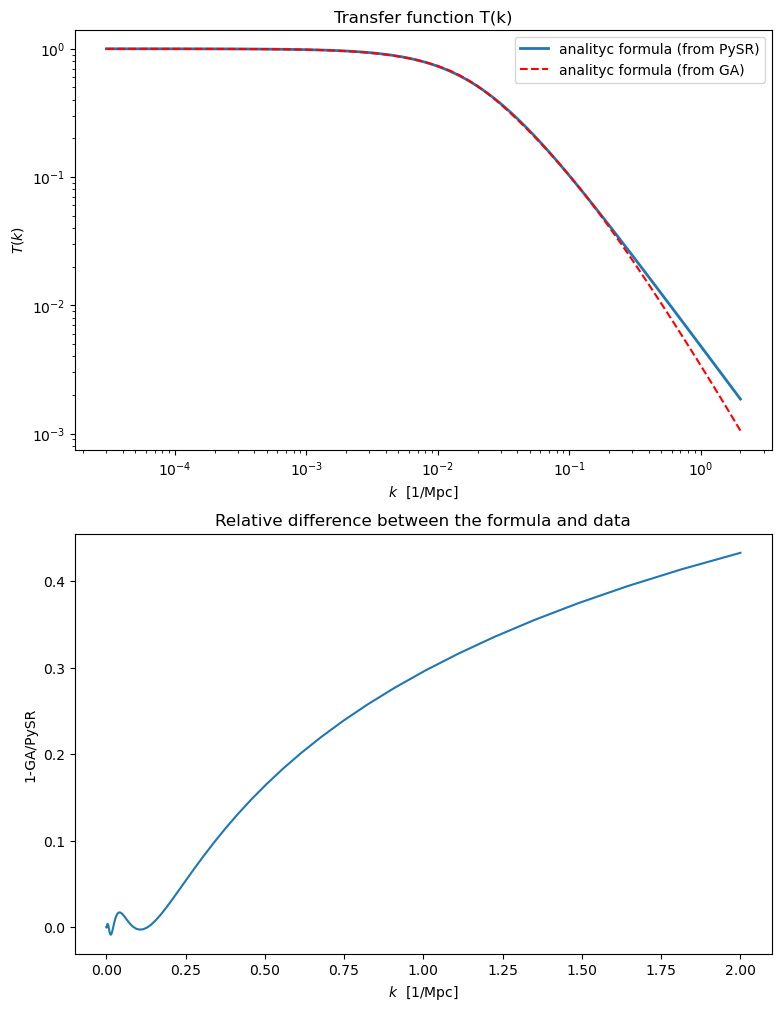

In [16]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(9,12))
pred = model.predict(x)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(k,pred, label='analityc formula (from PySR)', lw=2)
ax1.plot(k,T_, label='analityc formula (from GA)', linestyle="--", color='r')
ax1.set_xlabel(r'$k \,\,\,\, [1/\mathrm{Mpc}]$')
ax1.set_ylabel(r'$T(k)$')
ax1.set_title('Transfer function T(k)')
ax1.legend()

ax2.set_xlabel(r'$k \,\,\,\, [1/\mathrm{Mpc}]$')
ax2.set_ylabel(r'1-GA/PySR')
ax2.plot(k,1-T_/pred)
ax2.set_title('Relative difference between the formula and data')



It seems that the equation is too difficult to find it. Let's try for steps, with equations little by little more complicated:
n = k/(omega_m-omega_b)
y = T(n)
model.fit(x,y)
md(f"The model has this equation as output: ${model.latex()}$")
plt.plot(k,1-y/model.predict(x))
plt.semilogy(k,model.predict(x))
plt.semilogy(k,y)

# A new hope

Now we are generating data again with the analytic formula given by the paper, but now we are trying to replicate the choice of $k$ that they made.

(cit.) We consider that $\omega_b \in [0.0214,0.0234]$, and $\omega_m \in [0.13,0.15]$, and to see the dependence of the transfer function on these parameters, we make a grid of 4×4 pairs of $\{\omega_b, \omega_m\}$. For each considered cosmology (16 in total), we retrieve 114 points $\{k, T\}$. 

In [17]:
obar = np.linspace(0.0214, 0.0234, num=4, endpoint=True) #omega_b
omar = np.linspace(0.13, 0.15, num=4, endpoint=True) #omega_m

In [18]:
grid = [] #the pairs are (omega_b,omega_m)

for a in obar:
    line = []
    for b in omar:
        pair = (round(a, 4), round(b, 4))
        line.append(pair)
    grid.append(line)

Now, we calculate $x$:

In [19]:
k_ar = np.logspace(np.log10(3 * 10 ** -5), np.log10(2),num=114,endpoint=True)
x_1 = []
k_1 = []

for line in grid:
    for couple in line:
        a,b = couple
        x_1.append(k_ar/(b-a))
        k_1.append(k_ar)

x_1 = np.concatenate(x_1)
k_1 = np.concatenate(k_1)

Therefore, our preliminary dataset is composed by 1824 points. Now let's compute T(x) with the formula:

In [20]:
T_1 = T(x_1)

In [21]:
x_1 = x_1.reshape(-1,1)

In [22]:
model.fit(x_1,T_1)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1773: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


In [ ]:
md(f"The model has this equation as output: ${model.latex()}$")

In [ ]:
plt.scatter(x_1,T_1, s=1, label='From GA')
plt.scatter(x_1, model.predict(x_1), s=1, label='From PySR')
plt.loglog()
plt.legend()

In [ ]:
plt.scatter(k_1,1-T_1/model.predict(x_1),s=1)

In [ ]:
import glob

# Imposta il percorso della directory in cui cercare i file
directory_path = os.path.dirname('')

# Cerca i file che iniziano con 'hall_of_fame'
files_to_delete = glob.glob(os.path.join(directory_path, 'hall_of_fame*'))

# Elimina i file trovati
for file_path in files_to_delete:
    try:
        os.remove(file_path)
        print(f"File eliminato: {file_path}")
    except Exception as e:
        print(f"Errore durante l'eliminazione di {file_path}: {e}")